# Utilização de Redes Neurais Convolucionais para o Controle de Qualidade de Tomates

## Autor: André Rizzo

Este estudo tem o objetivo de utilizar Redes Neurais Convolucionais para a identificação do padrão de qualidade de tomates.
Ao final, o modelo deve ser capaz de identificar as seguintes classes de tomates:  
* Verdes (unripe)  
* Maduros (ripe)  
* Velhos (old)  
* Danificados (damaged)

Para este estudo estamos utilizando a base de dados https://www.kaggle.com/datasets/enalis/tomatoes-dataset .  

Inicialmente utilizarei o modelo VGG16 onde removerei as camadas finais do modelo original, adicionando novas camadas.  
Na sequência realizarei o fine tuning do novo modelo com as imagens da base acima.

In [1]:
import tensorflow as tf

from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa

import kagglehub

from google.colab import files
from google.colab import drive

import os

In [2]:
! pip install kaggle

In [3]:
# Cria diretório no Google Colab para armazenar a Kaggle Key
! mkdir ~/.kaggle

# Copia Kaggle Key do Google Drive para o Colab
!cp /content/drive/MyDrive/Projetos/Kaggle/kaggle.json ~/.kaggle/kaggle.json

# Faz o download da base de dados diretamente do Kaggle
! kaggle datasets download "enalis/tomatoes-dataset"

# Descompacta o arquivo com as fotos
! unzip tomatoes-dataset.zip > unzip_log.txt 2>&1

print('Imagens descompactadas e estrutura de pastas criada')

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/enalis/tomatoes-dataset
License(s): CC0-1.0
 97% 91.0M/93.7M [00:01<00:00, 77.4MB/s]
100% 93.7M/93.7M [00:01<00:00, 60.2MB/s]
Imagens descompactadas e estrutura de pastas criada


In [8]:
# Caminho base para os diretórios
base_path = "content/ieee-mbl-cls"

# Mapear nomes antigos para novos
rename_map = {
    "Damaged": "Danificado",
    "Old": "Velho",
    "Ripe": "Maduro",
    "Unripe": "Verde",
}

# Renomear os diretórios em train e val
for subfolder in ["train", "val"]:
    current_path = os.path.join(base_path, subfolder)
    for old_name, new_name in rename_map.items():
        old_path = os.path.join(current_path, old_name)
        new_path = os.path.join(current_path, new_name)
        if os.path.exists(old_path):  # Verifica se o diretório existe
            os.rename(old_path, new_path)
            print(f"Renomeado: {old_path} -> {new_path}")

Renomeado: content/ieee-mbl-cls/train/Damaged -> content/ieee-mbl-cls/train/Danificado
Renomeado: content/ieee-mbl-cls/train/Old -> content/ieee-mbl-cls/train/Velho
Renomeado: content/ieee-mbl-cls/train/Ripe -> content/ieee-mbl-cls/train/Maduro
Renomeado: content/ieee-mbl-cls/train/Unripe -> content/ieee-mbl-cls/train/Verde
Renomeado: content/ieee-mbl-cls/val/Damaged -> content/ieee-mbl-cls/val/Danificado
Renomeado: content/ieee-mbl-cls/val/Old -> content/ieee-mbl-cls/val/Velho
Renomeado: content/ieee-mbl-cls/val/Ripe -> content/ieee-mbl-cls/val/Maduro
Renomeado: content/ieee-mbl-cls/val/Unripe -> content/ieee-mbl-cls/val/Verde


#### Funções para visualização da qualidade do modelo

In [9]:
def plot_history(history):
  plt.figure(figsize=(12,5))

  plt.suptitle('Loss and Accuracy Plots', fontsize=18)

  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.legend()
  plt.xlabel('Number of epochs', fontsize=15)
  plt.ylabel('Loss', fontsize=15)

  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.legend()
  plt.xlabel('Number of epochs', fontsize=14)
  plt.ylabel('Accuracy', fontsize=14)
  plt.show()

#### Imagens para treinamento, validação e teste do modelo

In [10]:
# Caminho das imagens no Google Colab
train_path = "content/ieee-mbl-cls/train"
test_path = "content/ieee-mbl-cls/val"

In [11]:
# Carregar as imagens de treino e de validação
train_images = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,  # 20% dos dados para validação
    subset="training",
    seed=123,
    image_size=(224, 224),  # Redimensionar as imagens
    batch_size=32
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

class_names = train_images.class_names

Found 6500 files belonging to 4 classes.
Using 5200 files for training.
Found 6500 files belonging to 4 classes.
Using 1300 files for validation.
Found 724 files belonging to 4 classes.


#### Normalização das imagens

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_images_norm = train_images.map(lambda x, y: (normalization_layer(x), y))
val_images_norm = val_images.map(lambda x, y: (normalization_layer(x), y))
test_images_norm = test_images.map(lambda x, y: (normalization_layer(x), y))

#### Classes existentes

In [13]:
print("Classes:", class_names)

Classes: ['Danificado', 'Maduro', 'Velho', 'Verde']


#### Visualizar algumas imagens

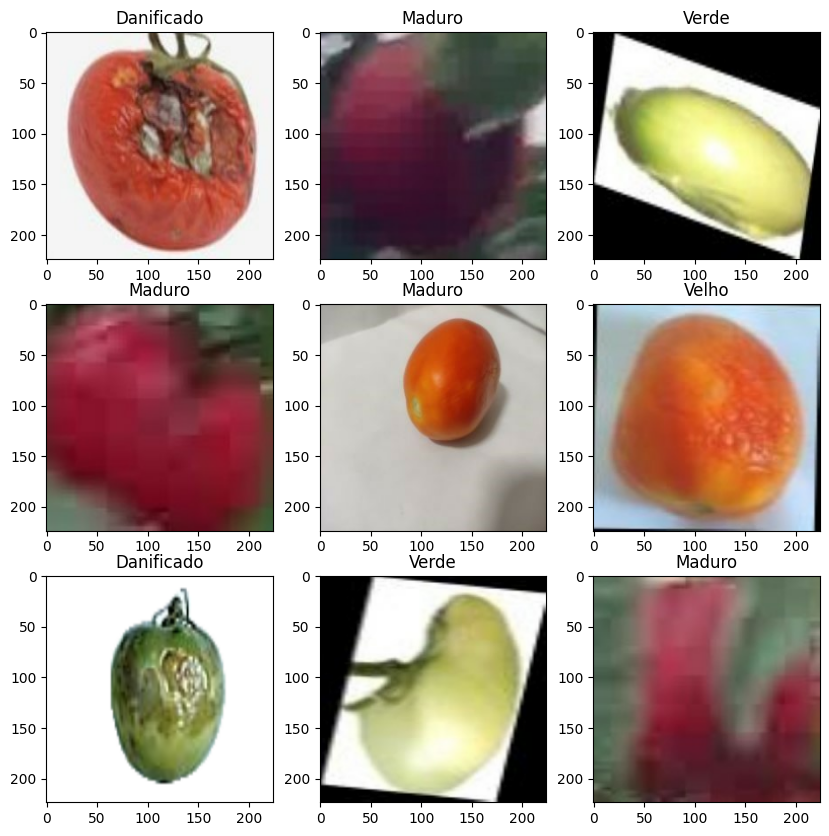

In [14]:
# Display some images and their labels
plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

#### Característica das imagens

In [15]:
image_batch, label_batch = next(iter(train_images))
print("Resolução das imagens para treinamento (pixels):", image_batch.shape)
print("Classes para treinamento", label_batch.shape)

image_batch_test, label_batch_test = next(iter(test_images))
print("\nResolução das imagens para teste (pixels):", image_batch_test.shape)
print("Classes para teste:", label_batch_test.shape)

Resolução das imagens para treinamento (pixels): (32, 224, 224, 3)
Classes para treinamento (32,)

Resolução das imagens para teste (pixels): (32, 224, 224, 3)
Classes para teste: (32,)


<br>

---  

## Criação dos modelos

### Transfer Learning  

Neste caso optei por utilizar o modelo VGG16 pelo seu bom desempenho sem um custo computacional elevado.  

A VGG 16 é composta de 13 camadas convolucionais, 5 camadas de max-pooling e 3 camadas totalmente conectadas. Portanto, o número de camadas com parâmetros ajustáveis ​​é 16 (13 camadas convolucionais e 3 camadas totalmente conectadas). É por isso que o nome do modelo é VGG 16.  

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*NNifzsJ7tD2kAfBXt3AzEg.png">  

Fonte: https://lekhuyen.medium.com/an-overview-of-vgg16-and-nin-models-96e4bf398484  

#### Carregar o modelo VGG16

In [16]:
modelo1 = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
modelo1.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Congelar todas as camadas

In [18]:
for layer in modelo1.layers[:]:
  layer.trainable = False

In [19]:
modelo1.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Criar o classificador

In [20]:
out_layers = Flatten()(modelo1.output)

out_layers = Dense(1024, activation="relu")(out_layers)
out_layers = Dropout(0.3)(out_layers)

out_layers = Dense(256, activation="relu")(out_layers)
out_layers = Dropout(0.3)(out_layers)

out_layers = Dense(4, activation="softmax")(out_layers) # Saída

modelo1 = keras.Model(inputs=modelo1.inputs, outputs=out_layers) # Junta as camadas

modelo1.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [21]:
modelo1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,669,252 (155.14 MB)

 Trainable params: 25,954,564 (99.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
# Callbacks para o treinamento
meus_callbacks = [
  keras.callbacks.EarlyStopping(patience=10),
  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                          patience=5, min_lr=0.00001),
  keras.callbacks.ModelCheckpoint(
        save_best_only=True,
        filepath='best_model.keras')
]

In [23]:
# Treinamento do modelo
history = modelo1.fit(train_images_norm,
                    validation_data = val_images_norm,
                    batch_size = 16,
                    callbacks = meus_callbacks,
                    epochs = 25)

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 314ms/step - accuracy: 0.4893 - loss: 2.0669 - val_accuracy: 0.8254 - val_loss: 0.4855 - learning_rate: 0.0010
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.7620 - loss: 0.5764 - val_accuracy: 0.8585 - val_loss: 0.3732 - learning_rate: 0.0010
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.8402 - loss: 0.4233 - val_accuracy: 0.8423 - val_loss: 0.4011 - learning_rate: 0.0010
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 162ms/step - accuracy: 0.8615 - loss: 0.3802 - val_accuracy: 0.8885 - val_loss: 0.2913 - learning_rate: 0.0010
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - accuracy: 0.8521 - loss: 0.3731 - val_accuracy: 0.8977 - val_loss: 0.2788 - learning_rate: 0.0010
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 186ms/step - accuracy: 0.8663 - loss: 0.3716 - val_accuracy: 0.9100 - val_loss: 0.2354 - learning_rate: 0.0010
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.8

#### Análise gráfica

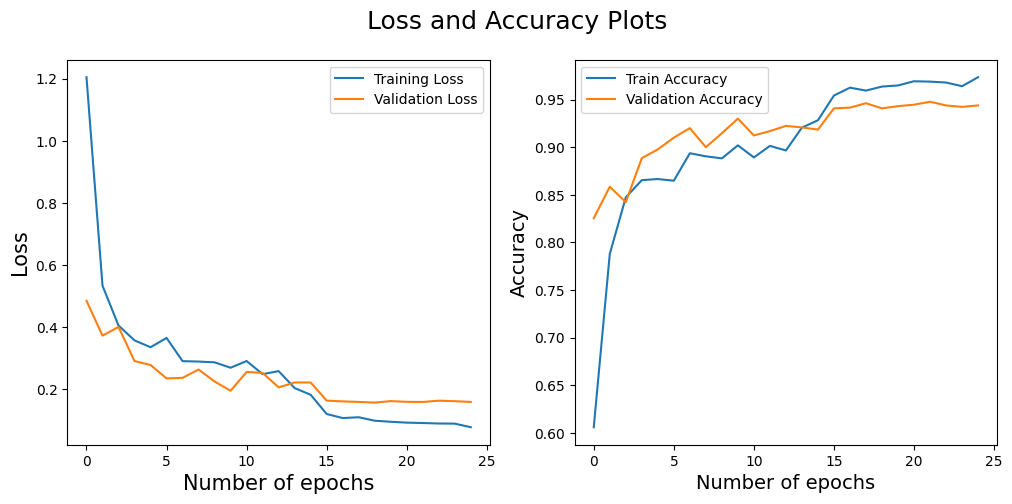

In [24]:
# Testa a rede e imprime histórico
plot_history(history)

#### Performance do modelo usando as imagens de teste

In [25]:
test_labels = []
for images, labels in test_images_norm:
    test_labels.extend(labels.numpy())
test_labels = np.array(test_labels)

test_loss, test_acc = modelo1.evaluate(test_images_norm)

print('\nPerda do modelo usando as imagens de teste:', test_loss)
print('\nAcurácia do modelo usando as imagens de teste', test_acc)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9543 - loss: 0.1342

Perda do modelo usando as imagens de teste: 0.18888641893863678

Acurácia do modelo usando as imagens de teste 0.9406077265739441


#### Classificações previstas pelo modelo vs reais

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


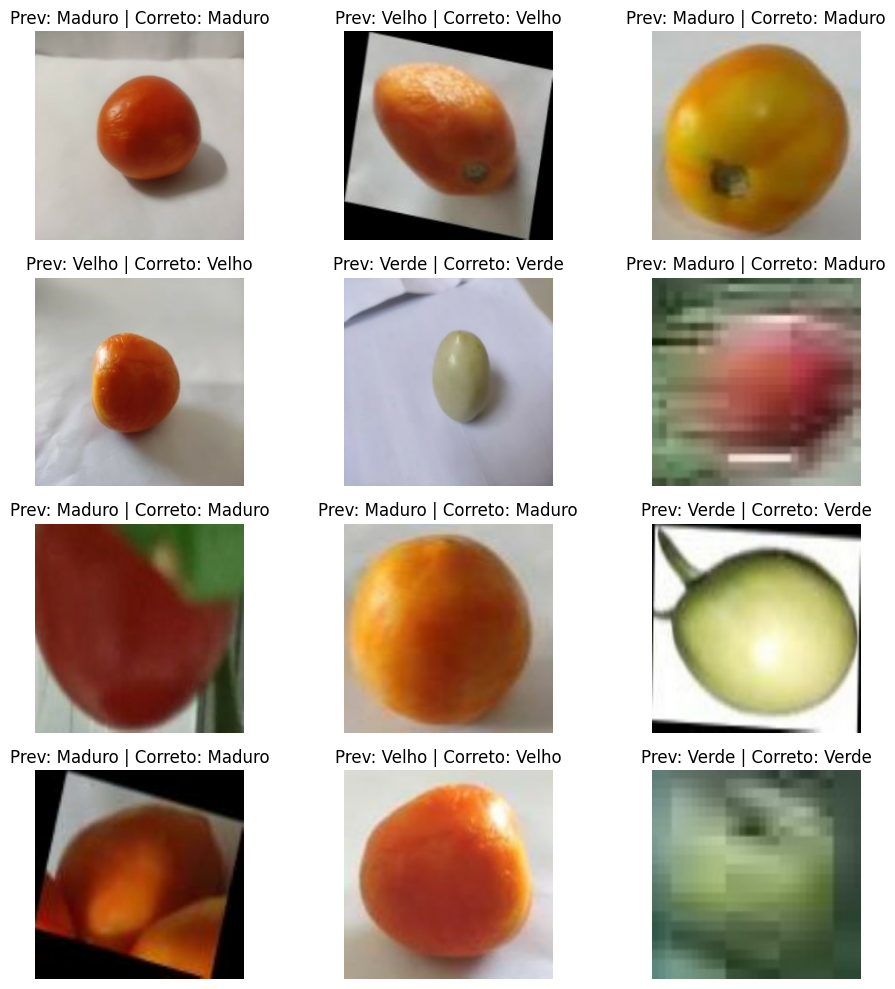

In [27]:
# Obter as classes do conjunto de teste
class_names = test_images.class_names

# Configurar o número de imagens a serem exibidas
num_images = 12

plt.figure(figsize=(10, 10))
count = 0

for images, labels in test_images_norm:
    predictions = modelo1.predict(images)  # Obter as predições
    predicted_labels = np.argmax(predictions, axis=1)  # Converter predições para índices das classes

    for i in range(len(labels)):
        if count < num_images:
            plt.subplot(4, 3, count + 1)
            plt.imshow((images[i].numpy() * 255).astype("uint8"))  # Exibir a imagem
            plt.axis("off")

            # Obter os rótulos
            true_label = class_names[labels[i].numpy()]
            predicted_label = class_names[predicted_labels[i]]

            # Adicionar os rótulos preditos e corretos
            plt.title(f"Prev: {predicted_label} | Correto: {true_label}")
            count += 1
        else:
            break
    if count >= num_images:
        break

plt.tight_layout()
plt.show()

#### Download do modelo para máquina local

In [28]:
files.download('best_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusão  

O modelo apresentou excelente performance com 94% de acurácia nas imagens de teste.  

<br>

## Próximos passos  


*   Gerar novas imagens para treinamento e testes por meio de *Data Augmentation* verificando em seguida se houve ganho de performance.   
*   Utilizar o modelo ResNet por meio de *Transfer Learning*, observando se houve ou não ganho de performance.  
*   Por fim, utilizar ambas abordagens acima em conjunto.  

